# Univariate, Multistep LSTM Implementation

An implementation of a univariate, multistep LSTM for the Close price of NYSE: ECL operating on daily resolution. The model uses 30 timesteps back to predict 30 timesteps forward. Data pre-processing has been completed in another notebook.

## Table of Contents
* Libraries
* Load Data
  * Split Data
* Vanilla LSTM
* LSTM Optimization
* LSTM Walk Forward Validation
* Validation Results
  * Overall
  * First Model
  * Last Model
* Conclusions

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import tqdm
%matplotlib inline

## Load the data
#### Daily Resolution Data

In [2]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('Clean Data/ECL_Clean_Day.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    print (df_day.shape)
    
#print (df_day.head(3))

(5031, 16)


#### Split the data

We'll use the past 10 years of data

In [3]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

Slice out 'Close' price from dataset

In [4]:
base_train = day_train['Close'] 
base_test = day_test['Close']

Plot the Test and Train split

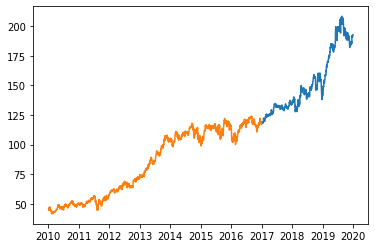

In [5]:
plt.plot(base_test)
plt.plot(base_train)
plt.show()

## Vanilla LSTM

Initialize a vanilla, stacked LSTM with two LSTM layers stacked and a single dense layer to provide the output.

Following Ex. 9.4.1, Univariate Multistep Forecasting with LSTM

In [6]:
# Multistep Data Preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 30, 30

# split into samples
X_train, y_train = split_sequence(base_train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(base_test.values, n_steps_in, n_steps_out)

# summarize the data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1703, 30) (1703, 30) (695, 30) (695, 30)


In [7]:
#Load required Keras modules
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
#print (X_train.shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
#print (X_test.shape)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
opt = Adam(lr=.001)
model.compile(optimizer=opt, loss='mse')
model.summary()
print ('\n')

# fit model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, 
                    batch_size=30,
                    verbose=1, 
                    shuffle=False)

Using TensorFlow backend.
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jacobscottant

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 124,230
Trainable params: 124,230
Non-trainable params: 0
_________________________________________________________________



Train on 1703 samples, validate on 695 samples
Epoch 1/20
1703/1703 [==============================] - 4s 2ms/step - loss: 22481.2097 - val_loss: 390045.3626
Epoch 2/20
1703/1703 [==============================] - 3s 2ms/step - loss: 129696.2955 - val_loss: 1306427.2428
Epoch 3/20
1703/1703 [==============================] - 3s 2ms/step - loss: 103670.7970 - val_loss: 1764

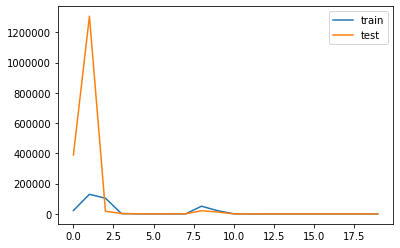

In [8]:
#Plot the Training and Validation Loss

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### LSTM Training Results
* Seems to be fine
* Looks OK
* What else can I do?

### Demonstrate Prediction

In [9]:
# Use X_test[0] as test
x_input = X_test[0]
print ('Shape of X_test[0]:,',X_test[0].shape)

# Reshape X_test[0]
x_input = x_input.reshape((1, n_steps_in, n_features))
print ('Shape of x_input:', x_input.shape)

# Make a prediction
yhat = model.predict(x_input, verbose=0)
print ('Shape of yhat:', yhat.shape)

Shape of X_test[0]:, (30, 1)
Shape of x_input: (1, 30, 1)
Shape of yhat: (1, 30)


Plot the input, output and prediction

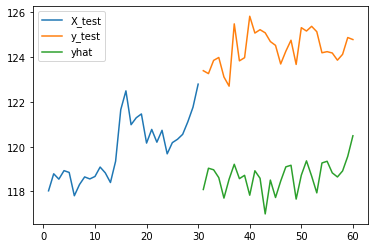

In [10]:
plt.plot(range(1,31), X_test[0], label = 'X_test')
plt.plot(range(31, 61), y_test[0], label = 'y_test')
plt.plot(range(31, 61), yhat[0], label = 'yhat')
plt.legend()
plt.show()

In [11]:
mae = metrics.mean_absolute_error(y_test[0], yhat[0])
rmse = metrics.mean_squared_error(y_test[0], yhat[0])
print ('Mean Absolute Error:', mae)
print ('Mean Squared Error:', rmse)

Mean Absolute Error: 5.710191497802736
Mean Squared Error: 33.55018757500237


* Results
* Results
* Results

## LSTM Architecture Optimization
* In order to arrive at an optimized architecture for the LSTM, I have used the ```talos``` library. This allows an extensive grid search to be setup and then automated. This has been conduced on a Google Cloud VM. The Jupyter Notebook used can be found here [here].
<br>
* The best architecture from this grid search is summarized below.

In [15]:
#Define the LSTM Model from the Talos grid search in a function to be called in the loop below

def LSTM_model():
    model = Sequential()
    model.add(LSTM(400, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(200, activation='relu'))
    model.add(Dense(90))
    model.add(Dropout(0.1))
    model.add(Dense(n_steps_out))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model

#### Optimized Architecture

In [16]:
model = LSTM_model()
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
lstm_8 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dense_6 (Dense)              (None, 90)                18090     
_________________________________________________________________
dropout_3 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                2730      
Total params: 1,144,820
Trainable params: 1,144,820
Non-trainable params: 0
_________________________________________________________________
None


* Discussion
* Discussion
* Discussion

## Walk-Forward Validation w/ re-fit

Validate the model by waking it forward on the training set. Testing set size is kept stationary. Step size is 30 which is intended to mimic a realistic situation of re-training once per month.

In [18]:
#Inputs for Walk-Forward with re-fit at each step
X = day_data['Close'] 
n_train = len(base_train)
n_records = len(base_train)+len(base_test)
step = 30
n_steps_in = 30
n_steps_out = 30
n_features = 1

pred_dict = dict()
errors = list()
count = 0

#Main Loop
for i in tqdm.tqdm_notebook(np.arange(n_train, n_records, step)):
    #split data
    train, test = X[0:i], X[n_train:]
    
    #rearrange to supervised
    X_train, y_train = split_sequence(train.values, n_steps_in, n_steps_out)
    X_test, y_test = split_sequence(test.values, n_steps_in, n_steps_out)
    
    #reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    
    #create model
    model = LSTM_model()
    es = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
    
    #fit the model
    model_fit = model.fit(X_train, y_train, 
                          validation_data=(X_test, y_test), 
                          epochs=100, 
                          callbacks=[es],
                          batch_size=30,
                          verbose=1, 
                          shuffle=False)
    
    #create the prediction counter for X_test loop
    time_count = 0
    
    #reset list for all the predictions
    predictions = list()
    
    #reset dict to catch all the output dfs (res)
    fore_dict = dict()
    
    #predict loop for each sample in X_test
    for t in np.arange(0, len(X_test), 1):
        x_input = X_test[t]
        x_input = x_input.reshape((1, n_steps_in, n_features))
        yhat = model.predict(x_input, verbose=0)
        predictions.append(yhat[0])
        
        #create output df and save into dict
        res = pd.DataFrame(list(range(1,n_steps_out+1)), columns=['Day'])
        res['Pred'] = yhat[0]
        fore_dict[time_count] = res
        time_count += 1
    
    pred_dict[count] = fore_dict
    
    #calculate error for all predictions (X_test)
    mae = metrics.mean_absolute_error(y_test, predictions)
    rmse = metrics.mean_squared_error(y_test, predictions)
    err = [count+1, mae, rmse]
    errors.append(err)
    
    #print update
    print('Step:',count+1)
    print('MAE:',mae)
    print('RMSE:',rmse)
    print('\n')
    
    #increase counter
    count += 1

Train on 1703 samples, validate on 695 samples
Epoch 1/100
1703/1703 [==============================] - 16s 9ms/step - loss: 1009056.2281 - val_loss: 158730.7780
Epoch 2/100
1703/1703 [==============================] - 15s 9ms/step - loss: 31798.2277 - val_loss: 8420.4639
Epoch 3/100
1703/1703 [==============================] - 15s 9ms/step - loss: 1676.5408 - val_loss: 694.4623
Epoch 4/100
1703/1703 [==============================] - 17s 10ms/step - loss: 780.4796 - val_loss: 370.9977
Epoch 5/100
1703/1703 [==============================] - 16s 9ms/step - loss: 743.9853 - val_loss: 396.5112
Epoch 6/100
1703/1703 [==============================] - 14s 8ms/step - loss: 564.0098 - val_loss: 380.3342
Epoch 7/100
1703/1703 [==============================] - 15s 9ms/step - loss: 516.4172 - val_loss: 337.4849
Epoch 8/100
1703/1703 [==============================] - 14s 8ms/step - loss: 511.8370 - val_loss: 333.2958
Epoch 9/100
1703/1703 [==============================] - 14s 8ms/step - loss:

1733/1733 [==============================] - 14s 8ms/step - loss: 8091.9398 - val_loss: 24364.6739
Epoch 10/100
1733/1733 [==============================] - 14s 8ms/step - loss: 8088.4556 - val_loss: 24354.9305
Epoch 11/100
1733/1733 [==============================] - 14s 8ms/step - loss: 95957349.8359 - val_loss: 24328.3184
Epoch 12/100
1733/1733 [==============================] - 14s 8ms/step - loss: 5401191.9652 - val_loss: 7537147.1942
Epoch 13/100
1733/1733 [==============================] - 14s 8ms/step - loss: 20628783.5072 - val_loss: 3441688.2554
Epoch 14/100
1733/1733 [==============================] - 14s 8ms/step - loss: 1309828.6683 - val_loss: 179184.0762
Epoch 15/100
1733/1733 [==============================] - 14s 8ms/step - loss: 20762.2804 - val_loss: 9590.4125
Epoch 16/100
1733/1733 [==============================] - 14s 8ms/step - loss: 1680.1073 - val_loss: 1208.6194
Epoch 17/100
1733/1733 [==============================] - 14s 8ms/step - loss: 874.1649 - val_loss:

Epoch 84/100
1733/1733 [==============================] - 13s 8ms/step - loss: 426.5427 - val_loss: 322.4435
Epoch 85/100
1733/1733 [==============================] - 13s 8ms/step - loss: 431.2509 - val_loss: 323.7580
Epoch 86/100
1733/1733 [==============================] - 13s 8ms/step - loss: 418.3933 - val_loss: 455.4491
Epoch 87/100
1733/1733 [==============================] - 13s 8ms/step - loss: 425.0042 - val_loss: 294.0694
Epoch 88/100
1733/1733 [==============================] - 13s 8ms/step - loss: 431.9559 - val_loss: 309.7224
Epoch 89/100
1733/1733 [==============================] - 13s 8ms/step - loss: 438.9997 - val_loss: 426.3728
Epoch 90/100
1733/1733 [==============================] - 13s 8ms/step - loss: 422.7306 - val_loss: 367.7093
Epoch 91/100
1733/1733 [==============================] - 13s 8ms/step - loss: 437.8359 - val_loss: 290.3518
Step: 2
MAE: 13.848314595423851
RMSE: 290.35170887143323


Train on 1763 samples, validate on 695 samples
Epoch 1/100
1763/1763 

1793/1793 [==============================] - 14s 8ms/step - loss: 55.2018 - val_loss: 104.3980
Epoch 34/100
1793/1793 [==============================] - 14s 8ms/step - loss: 53.2748 - val_loss: 100.2079
Epoch 35/100
1793/1793 [==============================] - 14s 8ms/step - loss: 54.1652 - val_loss: 99.6554
Epoch 36/100
1793/1793 [==============================] - 14s 8ms/step - loss: 54.7375 - val_loss: 76.0960
Epoch 37/100
1793/1793 [==============================] - 14s 8ms/step - loss: 53.2966 - val_loss: 71.6711
Epoch 38/100
1793/1793 [==============================] - 14s 8ms/step - loss: 54.7470 - val_loss: 99.8805
Epoch 39/100
1793/1793 [==============================] - 14s 8ms/step - loss: 57.1604 - val_loss: 105.8774
Step: 4
MAE: 8.080282608926531
RMSE: 105.87744273510889


Train on 1823 samples, validate on 695 samples
Epoch 1/100
1823/1823 [==============================] - 16s 9ms/step - loss: 27651.9252 - val_loss: 2767.0888
Epoch 2/100
1823/1823 [======================

KeyboardInterrupt: 

## Validation Results

Plot the first and last models trained and compare their skill in terms of error. I'm using Mean Absolute Error and Mean Squared Error as the primary measures of model accuracy.

### Overall Model Error

When we calculate the errors, we're looking at each prediction at each timestep (724 samples x 30 timesteps prediction = 21,720 predictions).

In [ ]:
error_df = pd.DataFrame.from_records(errors, columns=['Iteration', 'MAE', 'RMSE'])
ax = error_df.plot(x='Iteration', y=['MAE', 'RMSE'], secondary_y=['RMSE'],
             figsize=(15,4),
             title='Error vs. Iteration',
             colormap='jet')
ax.set(ylabel='Error')
plt.show()

* Observation
* Observation
* Observation

Now, we'll zoom into two specific iterations (first and last) and explore their skill more deeply.

#### Plot the First and Last Model
I'll create a single composite line from the model by sampling every 30th prediction (30 steps long) to create a single line. 26 steps x 30 timesteps prediction = 780 predictions
#### First Model

In [ ]:
# Plot the first model (least training data) by sampling every 30th prediction (step) and appending to a list

first_model = []
for i in np.arange(0, len(X_test), step):
    first_model.append(pred_dict[0][i]['Pred'])

#unravel the array to plot the prediction over the actual
first_pred = np.concatenate(first_model).ravel().tolist()

#create a df with the timestamps and actual Close prices
first_results = pd.DataFrame(base_test) #base_test[step:]

#trim the length to match base_test as the last step isn't exactly 30 due to training set size
first_results = first_results[:len(first_pred)]

#add the prediction to the df
first_results['Pred'] = first_pred

#plot the df
first_results.plot(figsize=(15,5), title='First Model Composite Prediction vs Actual')

In [ ]:
#Aggregate Error for the Composite Line above

first_total_MAE = metrics.mean_absolute_error(first_results['Close'], first_results['Pred'])
first_total_RMSE = metrics.mean_squared_error(first_results['Close'], first_results['Pred'])

print('Aggregate Error for the Composite Line')
print('Mean Absolute Error:',first_total_MAE)
print('Mean Squared Error:',first_total_RMSE)

In [ ]:
#Pearson Correlation for First Model

first_corr = first_results.corr(method='pearson')['Close']['Pred']
print ('Pearson Correlation for Close & Prediction:',first_corr)

In [ ]:
#Plot the First Models Error by Prediction Horizon ie. Error at t+1 through t+30

first_error = pred_dict[0][0]

#Sample the predictions
for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[0][i])
    three = first_error.append(two, ignore_index=True)
    first_error = three

#Add the Actual Values
first_error['Actual'] = base_test.values[0:len(first_error)]

#intialize a list
first_error_by_day = list()

#calcualte the errors at each day by slicing the df
for i in range(1,31):
    df = first_error[first_error.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    first_error_by_day.append(error)

In [ ]:
#Plot the Error vs Day

first_error_day = pd.DataFrame.from_records(first_error_by_day, columns=['Day', 'MAE', 'RMSE'])
first_ax = first_error_day.plot(x='Day', y=['MAE','RMSE'], 
                          secondary_y=['RMSE'],
                         title = 'Errors vs Prediction Horizon')
first_ax.set(ylabel='Error')
plt.show()

Observations:
* One
* Two
* Three

#### Last Model

In [ ]:
# Plot the last model (most training data) by sampling every 30th prediction (step) and appending to a list

last_model = []
for i in np.arange(0,len(X_test),step):
    last_model.append(pred_dict[max(pred_dict)][i]['Pred'])

#unravel the array to plot the prediction over the actual
last_pred = np.concatenate(last_model).ravel().tolist()

#create a df with the timestamps and actual Close prices
last_results = pd.DataFrame(base_test) #base_test[step:]

#trim the length to match base_test as the last step isn't exactly 30 due to training set size
last_results = last_results[:len(last_pred)]

#add the prediction to the df
last_results['Pred'] = last_pred

#plot the df
last_results.plot(figsize=(15,5), title='Last Model Composite Prediction vs Actual')

In [ ]:
#Aggregate Error for the Composite Line above
last_total_MAE = metrics.mean_absolute_error(last_results['Close'], last_results['Pred'])
last_total_RMSE = metrics.mean_squared_error(last_results['Close'], last_results['Pred'])

print('Aggregate Error for the Composite Line')
print('Mean Absolute Error:',last_total_MAE)
print('Mean Squared Error:',last_total_RMSE)

In [ ]:
last_corr = last_results.corr(method='pearson')['Close']['Pred']
print ('Pearson Correlation for Close & Prediction:',last_corr)

In [ ]:
#sample the last models predicitons to see the error by forecast day

last_error = pred_dict[max(pred_dict)][0]

#sample the predictions
for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[max(pred_dict)][i])
    three = last_error.append(two, ignore_index=True)
    last_error = three

#add in the actual values
last_error['Actual'] = base_test.values[0:len(last_error)]

#create a list
last_error_by_day = list()

#calculate the error by day
for i in range(1,31):
    df = last_error[last_error.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    last_error_by_day.append(error)

In [ ]:
#Plot the Error vs Day

last_error_day = pd.DataFrame.from_records(last_error_by_day, columns=['Day', 'MAE', 'RMSE'])
last_ax = last_error_day.plot(x='Day', y=['MAE','RMSE'], 
                          secondary_y=['RMSE'],
                         title = 'Errors vs Prediction Horizon')
last_ax.set(ylabel='Error')
plt.show()

Hmmm. Model performance is garbage, especially towards the end. I believe I need to retrain at each step.
* Other thing
* Other thing
* Other things

## Conclusion

This optimized architecture was able to achieve